In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scipy.sparse as sp

import scmomat 

plt.rcParams["font.size"] = 10

## Step 1: Load dataset
Make sure that the dataset get stored in a dictionary (`counts` in the script), with the item:
* `nbatches`: total number of batches
* `feats_name`: a dictionary storing the feature names for different modalities, e.g. `{"rna": np.array([aaaa, bbbb,...]), "atac": np.array([ccc, ddd, ...]), "protein": np.array([eee, fff, ...])}`
* `modality 1` (e.g. `rna` in the example below): a `list` store all data matrices correspond to modality 1, a element correspond to one batch, elements are ordered in the list following the ordering of batches. **The batches that does not have count matrix in corresponding modality is inserted `None` as placeholder**
* `modality 2` (e.g. `atac` in the example below): requirement the same as above.
* `modality 3` (e.g. `protein`): requirement the same as above.
* ...

#### Note:
* The number of item in the `feats_name` should match the number of modalities in `counts`. 
* The length of lists in `modality 1`, `modality 2`, `modality 3`, etc should have the same length, which is equal to `nbatches`. (missing matrices are denoted as `None` as explained above). **The matrices must be ordered according to the batch ID in each list,** so that scMoMaT can detact parallel sequenced batches.
* The data matrix in each modality (each list) should have the same set of features. You can do thie by 1. using the intersection of all genes/proteins in different batches; 2. Remap the chromatin regions according to the peaks of one batch. 
* The data matrix is of the shape `(ncells, nfeatures)`, and preprocessed with `utils.preprocess()` function.

One example template is shown as below, note that the features of data matrices are matched in advance. The connection matrix (`GxR.npz`) that is used to generate pseudo-count is also provided in advance (used the code in folder `calc_pseudo_count/calc_pseudo_count.R`). Feel free to modify on the template to use your dataset.


In [2]:
data_dir = "./data/real/MOp_5batches/"

# number of batches
n_batches = 5

# obtain the feature name
genes = pd.read_csv(data_dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(data_dir + "regions.txt", header = None).values.squeeze()
feats_name = {"rna": genes, "atac": regions}

# READ IN THE COUNT MATRICES
# scATAC-seq of batch 1
counts_atac1 = np.array(sp.load_npz(os.path.join(data_dir, "RxC1.npz")).todense().T)
counts_atac1 = scmomat.preprocess(counts_atac1, modality = "ATAC")
# scATAC-seq of batch 3
counts_atac3 = np.array(sp.load_npz(os.path.join(data_dir, "RxC3.npz")).todense().T)
counts_atac3 = scmomat.preprocess(counts_atac3, modality = "ATAC")
# scATAC-seq of batch 5
counts_atac5 = np.array(sp.load_npz(os.path.join(data_dir, "RxC5.npz")).todense().T)
counts_atac5 = scmomat.preprocess(counts_atac5, modality = "ATAC")
# list containing scATAC-seq of all batches, the batches that do not have matrix are filled in with None
counts_atacs = [counts_atac1, None, counts_atac3, None, counts_atac5]

# scRNA-seq of batch 1
counts_rna1 = np.array(sp.load_npz(os.path.join(data_dir, "GxC1.npz")).todense().T)
counts_rna1 = scmomat.preprocess(counts_rna1, modality = "RNA", log = False)
# scRNA-seq of batch 2
counts_rna2 = np.array(sp.load_npz(os.path.join(data_dir, "GxC2.npz")).todense().T)
counts_rna2 = scmomat.preprocess(counts_rna2, modality = "RNA", log = False)
# scRNA-seq of batch 4
counts_rna4 = np.array(sp.load_npz(os.path.join(data_dir, "GxC4.npz")).todense().T)
counts_rna4 = scmomat.preprocess(counts_rna4, modality = "RNA", log = False)
# list containing scRNA-seq of all batches, the batches that do not have matrix are filled in with None
counts_rnas = [counts_rna1, counts_rna2, None, counts_rna4, None]

# CALCULATE THE PSEUDO-COUNT MATRIX
# Load the gene by region association matrix
A = sp.load_npz(os.path.join(data_dir, 'GxR.npz'))
A = np.array(A.todense())
# Calculate the pseudo-scRNA-seq matrix of batch 2
counts_rnas[2] = counts_atacs[2] @ A.T
# Binarize
counts_rnas[2] = (counts_rnas[2]!=0).astype(int)
# Calculate the pseudo-scRNA-seq matrix of batch 4
counts_rnas[4] = counts_atacs[4] @ A.T
# Binarize
counts_rnas[4] = (counts_rnas[4]!=0).astype(int)

# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 400.9384
	 loss reconstruction: 0.40022
	 loss regularization: 0.72000
Epoch 1000, Validating Loss: 285.6613
	 loss reconstruction: 0.28560
	 loss regularization: 0.05899
Epoch 2000, Validating Loss: 281.0051
	 loss reconstruction: 0.28097
	 loss regularization: 0.03670
Epoch 3000, Validating Loss: 279.3571
	 loss reconstruction: 0.27932
	 loss regularization: 0.03583
Epoch 4000, Validating Loss: 278.3958
	 loss reconstruction: 0.27837
	 loss regularization: 0.02659
running time: 189.92933058738708


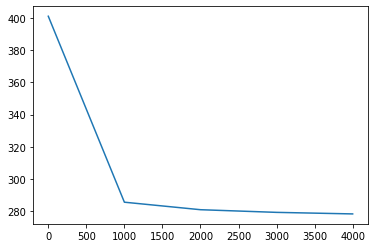

In [3]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Here we list other parameters in the function for illustration purpose, most of these parameters are set as default value.
# weight on regularization term, default value
lamb = 0.001 
# number of total iterations, default value
T = 4000
# print the result after each ``interval'' iterations, default value
interval = 1000
# batch size for each iteraction, default value
batch_size = 0.1
# learning rate, default value
lr = 1e-2
# random seed, default value
seed = 0
# running device, can be CPU or GPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

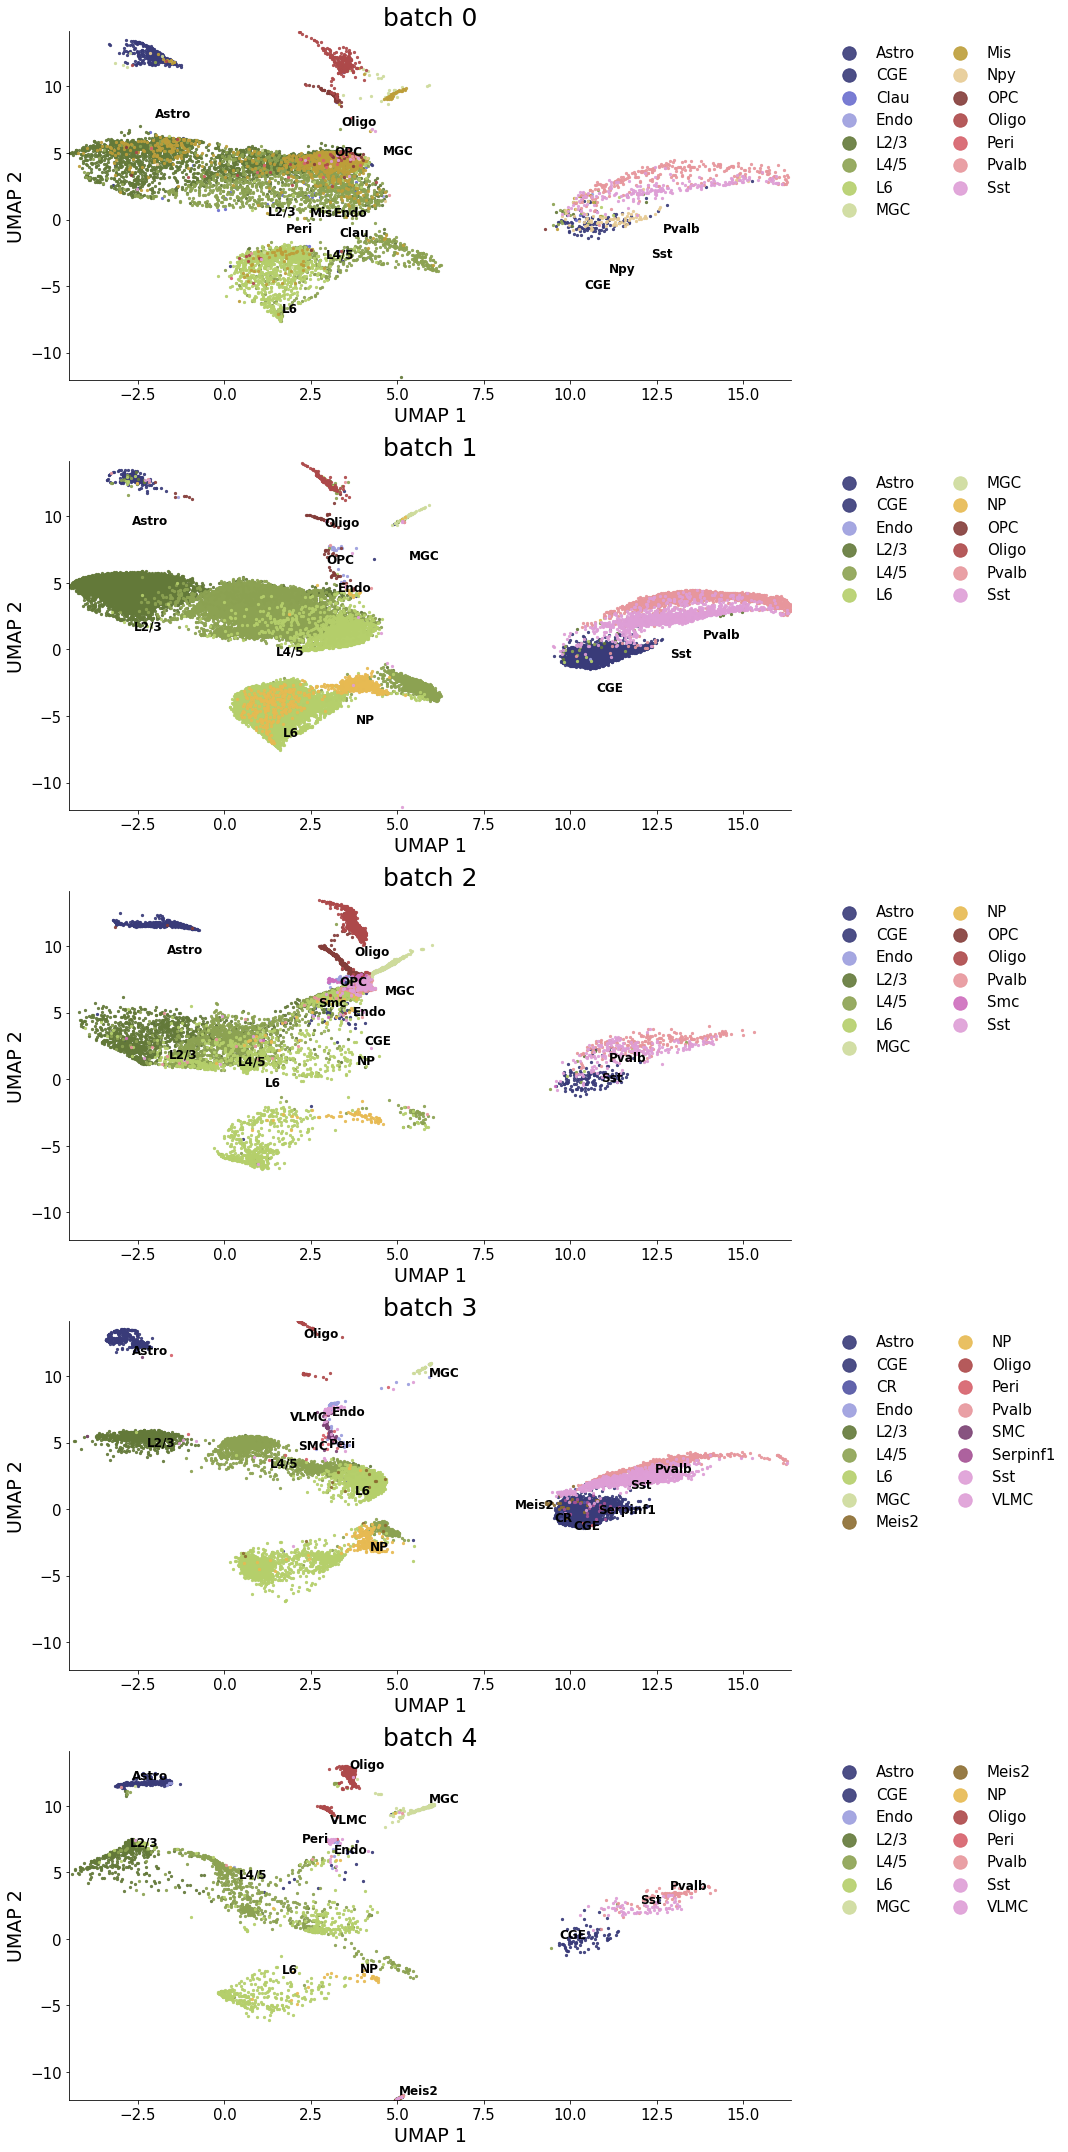

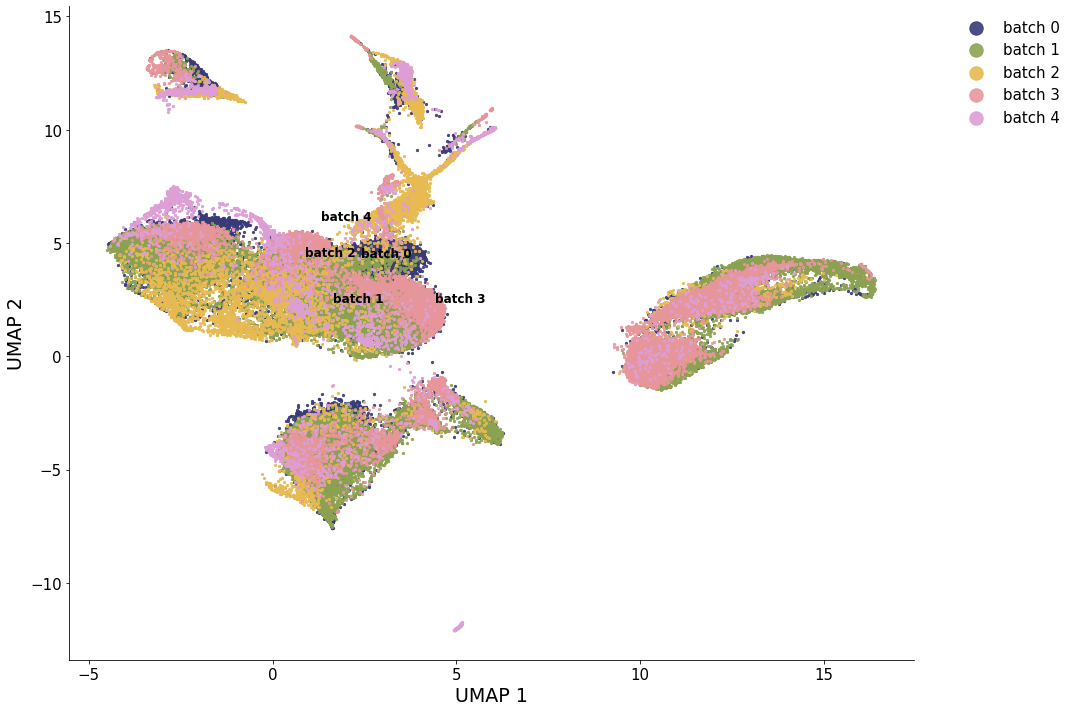

In [4]:
# read in the ground truth labels
labels = []
labels_batches = []
for batch in range(n_batches):
    labels.append(pd.read_csv(os.path.join(data_dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster (remapped)"].values.squeeze())        
    labels_batches.append(np.array(["batch " + str(batch)] * len(labels[-1]), dtype = object))


# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), batches = np.concatenate(labels_batches), mode = "separate", save = None, figsize = (15,30), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(labels_batches), mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

calculating pairwise distance, time used 18.0164s
knn separate, time used 11.7555s
modify distance 1, time used 0.0365s
not unique
using precompute
Provided KNN...


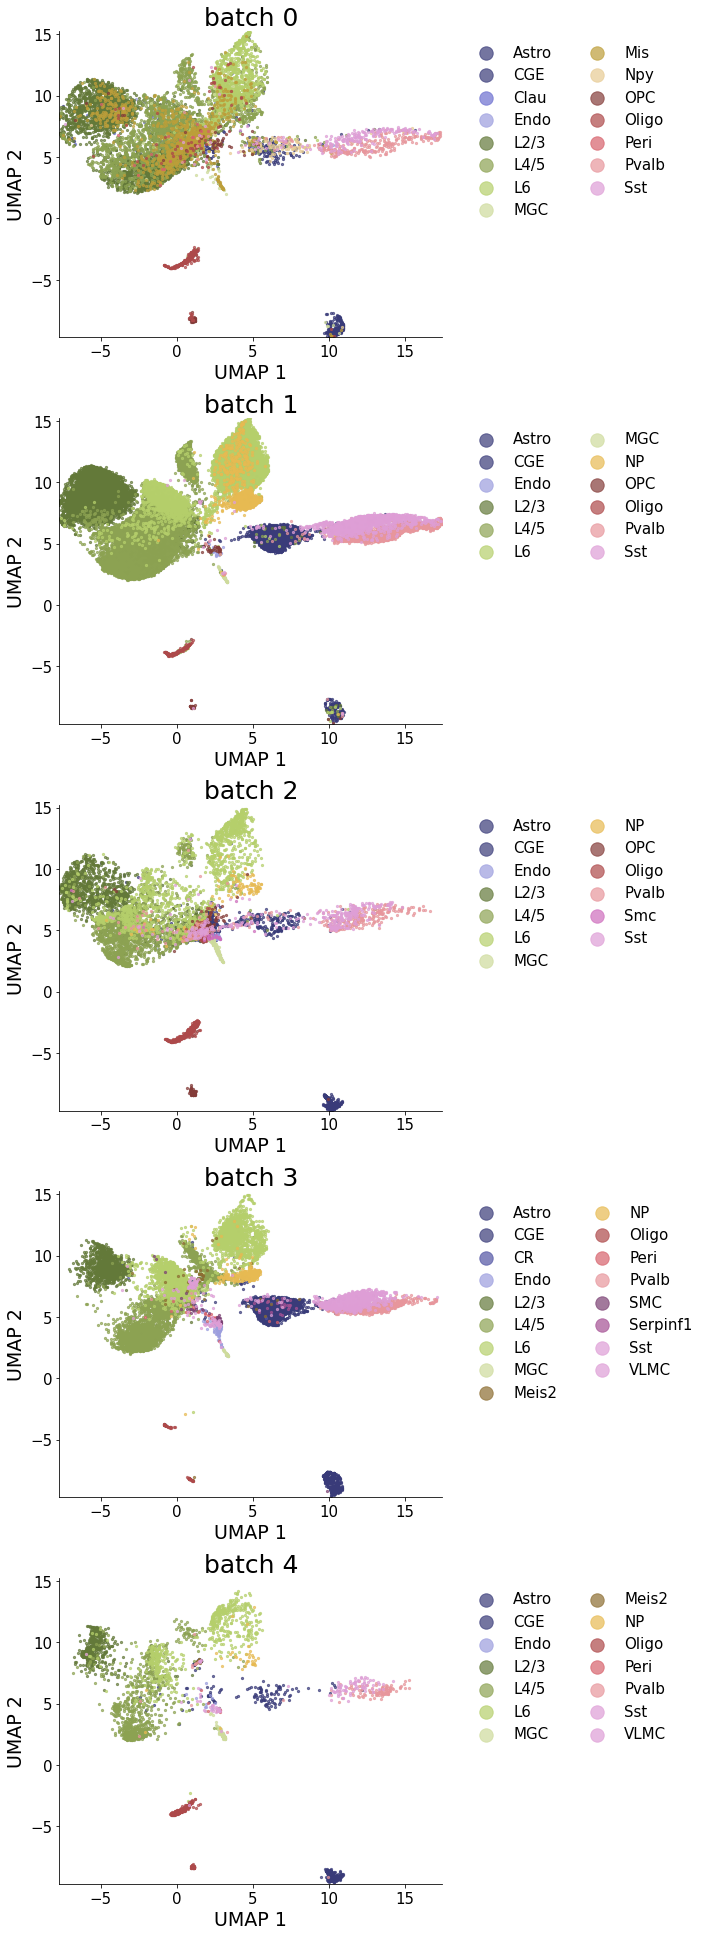

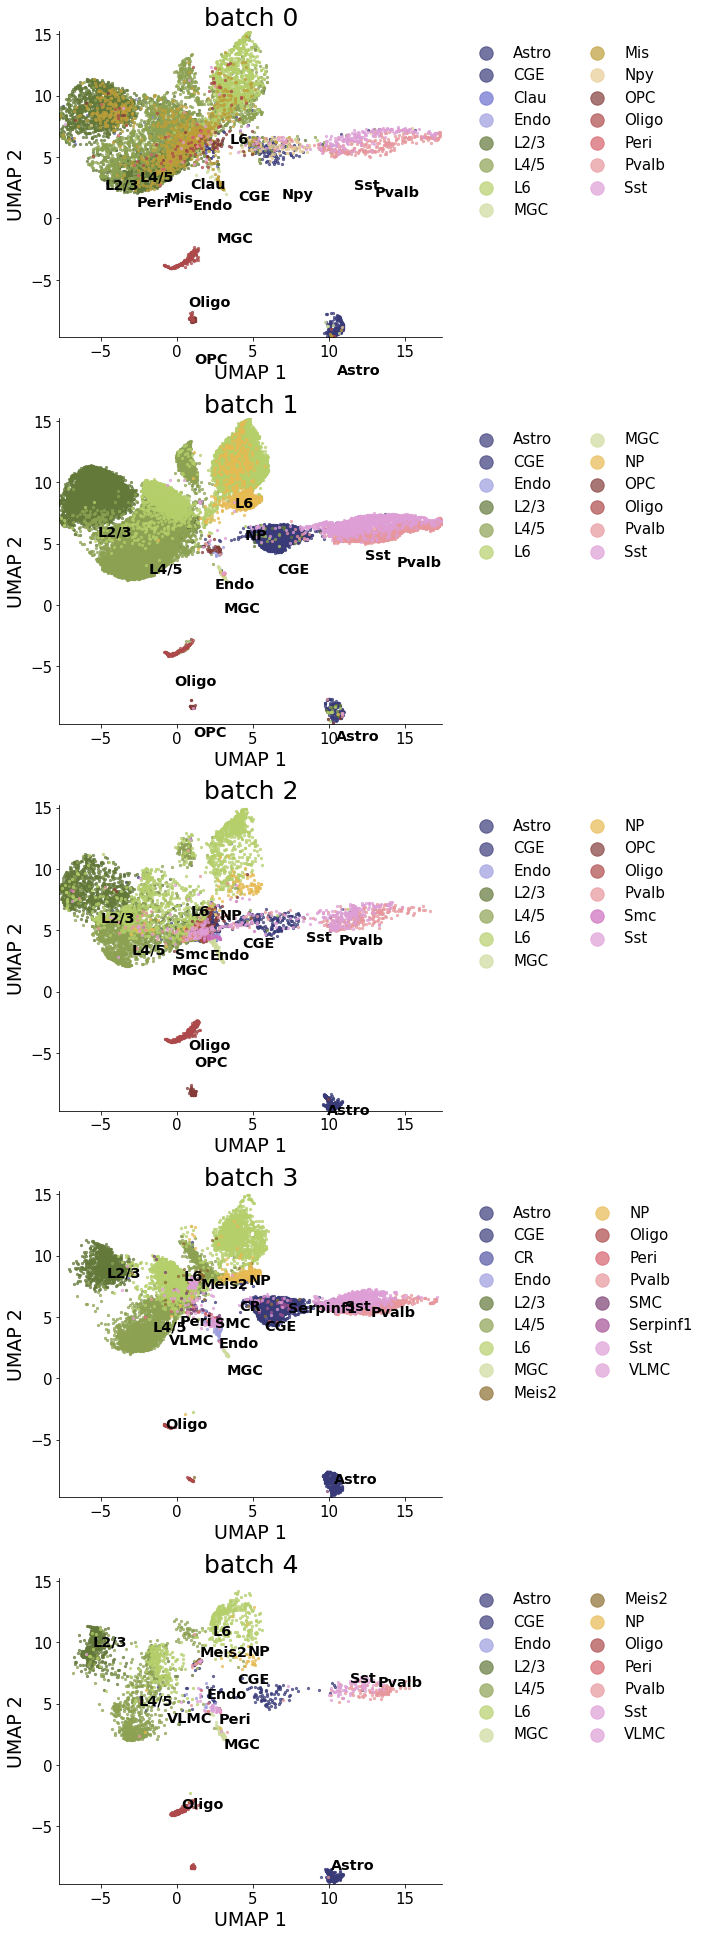

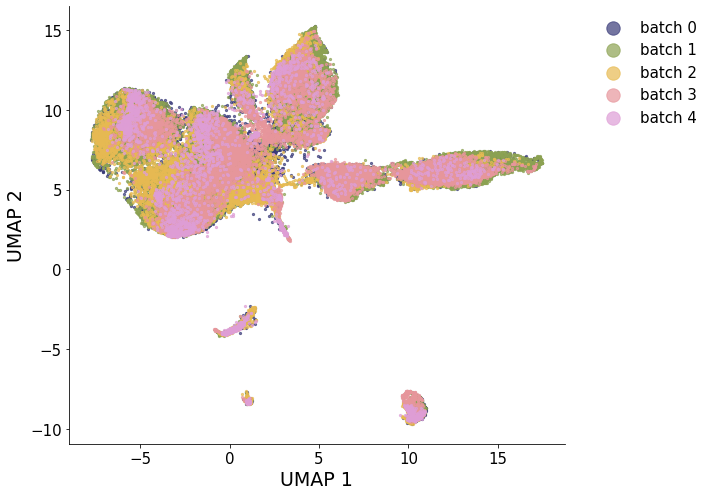

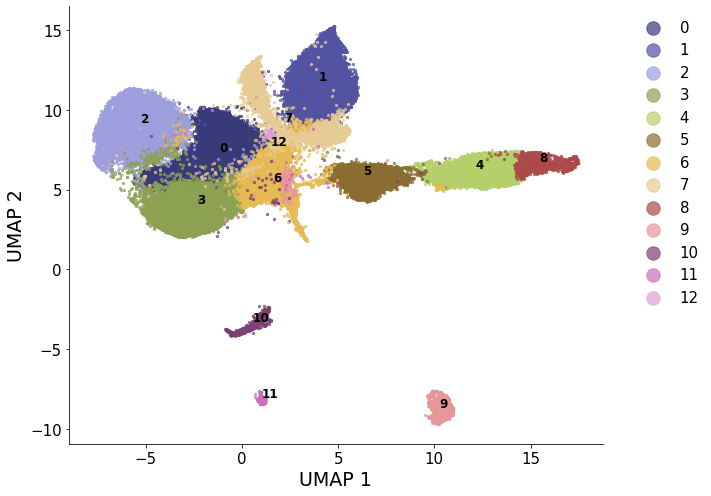

In [5]:
zs = model.extract_cell_factors()

n_neighbors = 100
r = None
s_pair_dist, knn_indices, knn_dists = scmomat.post_process(zs, n_neighbors, njobs = 8, r = r)


resolution = 0.9
labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
umap_op = scmomat.UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), batches = np.concatenate(labels_batches), mode = "separate", save = None,\
                      figsize = (10,27), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = False, alpha = 0.7, text_size = "x-large")

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), batches = np.concatenate(labels_batches), mode = "separate", save = None,\
                      figsize = (10,27), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True, alpha = 0.7, text_size = "x-large")

scmomat.plot_latent(x_umap, annos = np.concatenate(labels_batches), mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

scmomat.plot_latent(x_umap, annos = labels_leiden, mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True, alpha = 0.7)



## Step 4: Retraining model
* If you have additional data matrices for the existing batches (e.g. motif matrix from chromVAR), you can insert the data matrices into `count` during that phase. The additional matrices are considered as new modalities, same requirements in step1 apply.
* If you don't have additional data matrice, you can directly go to the second cell below for retraining.

In [6]:
# INCLUDE MOTIF MATRIX INTO COUNTS OBJECT
# read in motif dataset
counts_motif3 = pd.read_csv(data_dir + f'MxC3_raw.csv', index_col = 0).T
counts_motif3 = counts_motif3.fillna(0)
motifs = counts_motif3.columns.values
counts_motif3 = counts_motif3.values
# chromVAR provide the z-score, which has negative values
counts_motif3 = (counts_motif3 - np.min(counts_motif3))/(np.max(counts_motif3) - np.min(counts_motif3) + 1e-6)
# list containing motif matrix of all batches, the batches that do not have matrix are filled in with None
counts_motifs = [None, None, counts_motif3, None, None]
counts["motif"] = counts_motifs
counts["feats_name"]["motif"] = motifs


Epoch 1, Validating Loss: 879.3430
	 loss reconstruction: 0.40632
	 loss regularization: 473.02417
Epoch 1000, Validating Loss: 293.6353
	 loss reconstruction: 0.29310
	 loss regularization: 0.53791
Epoch 2000, Validating Loss: 293.3920
	 loss reconstruction: 0.29284
	 loss regularization: 0.55171


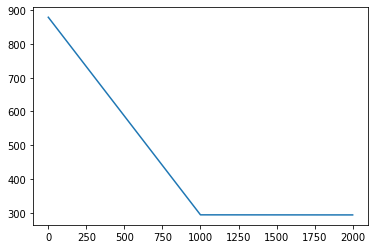

In [7]:
# use the updated count object and learned cluster label (labels_leiden)
# number of iterations
T = 2000
model2 = scmomat.scmomat_retrain(model = model, counts =  counts, labels = labels_leiden, lamb = lamb, device = device)
losses = model2.train(T = T)
# extract marker feature scores
C_feats = model2.extract_marker_scores()

x = np.linspace(0, T, int(T/interval) + 1)
plt.plot(x, losses)


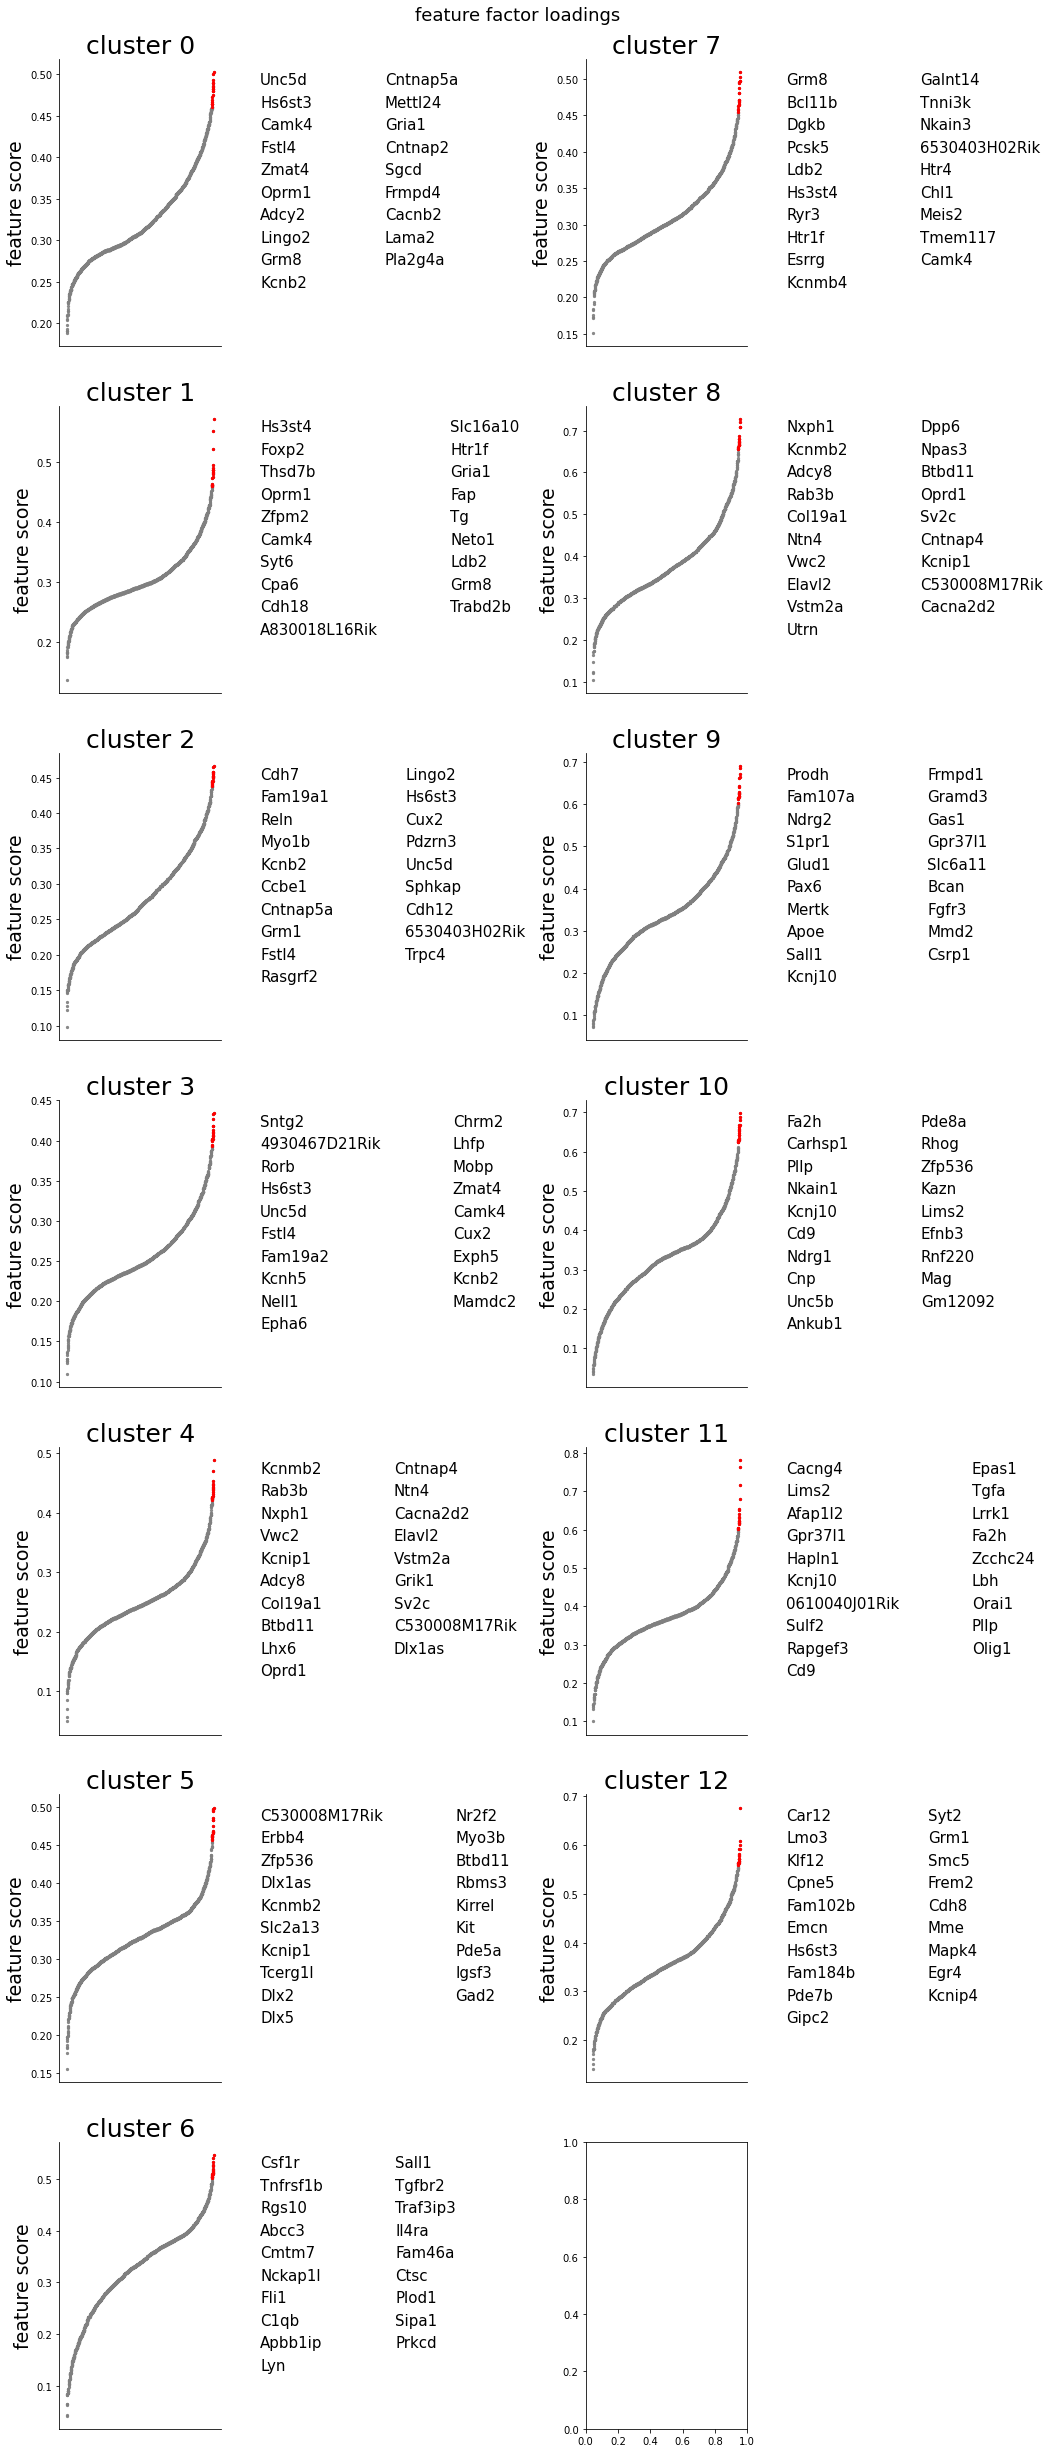

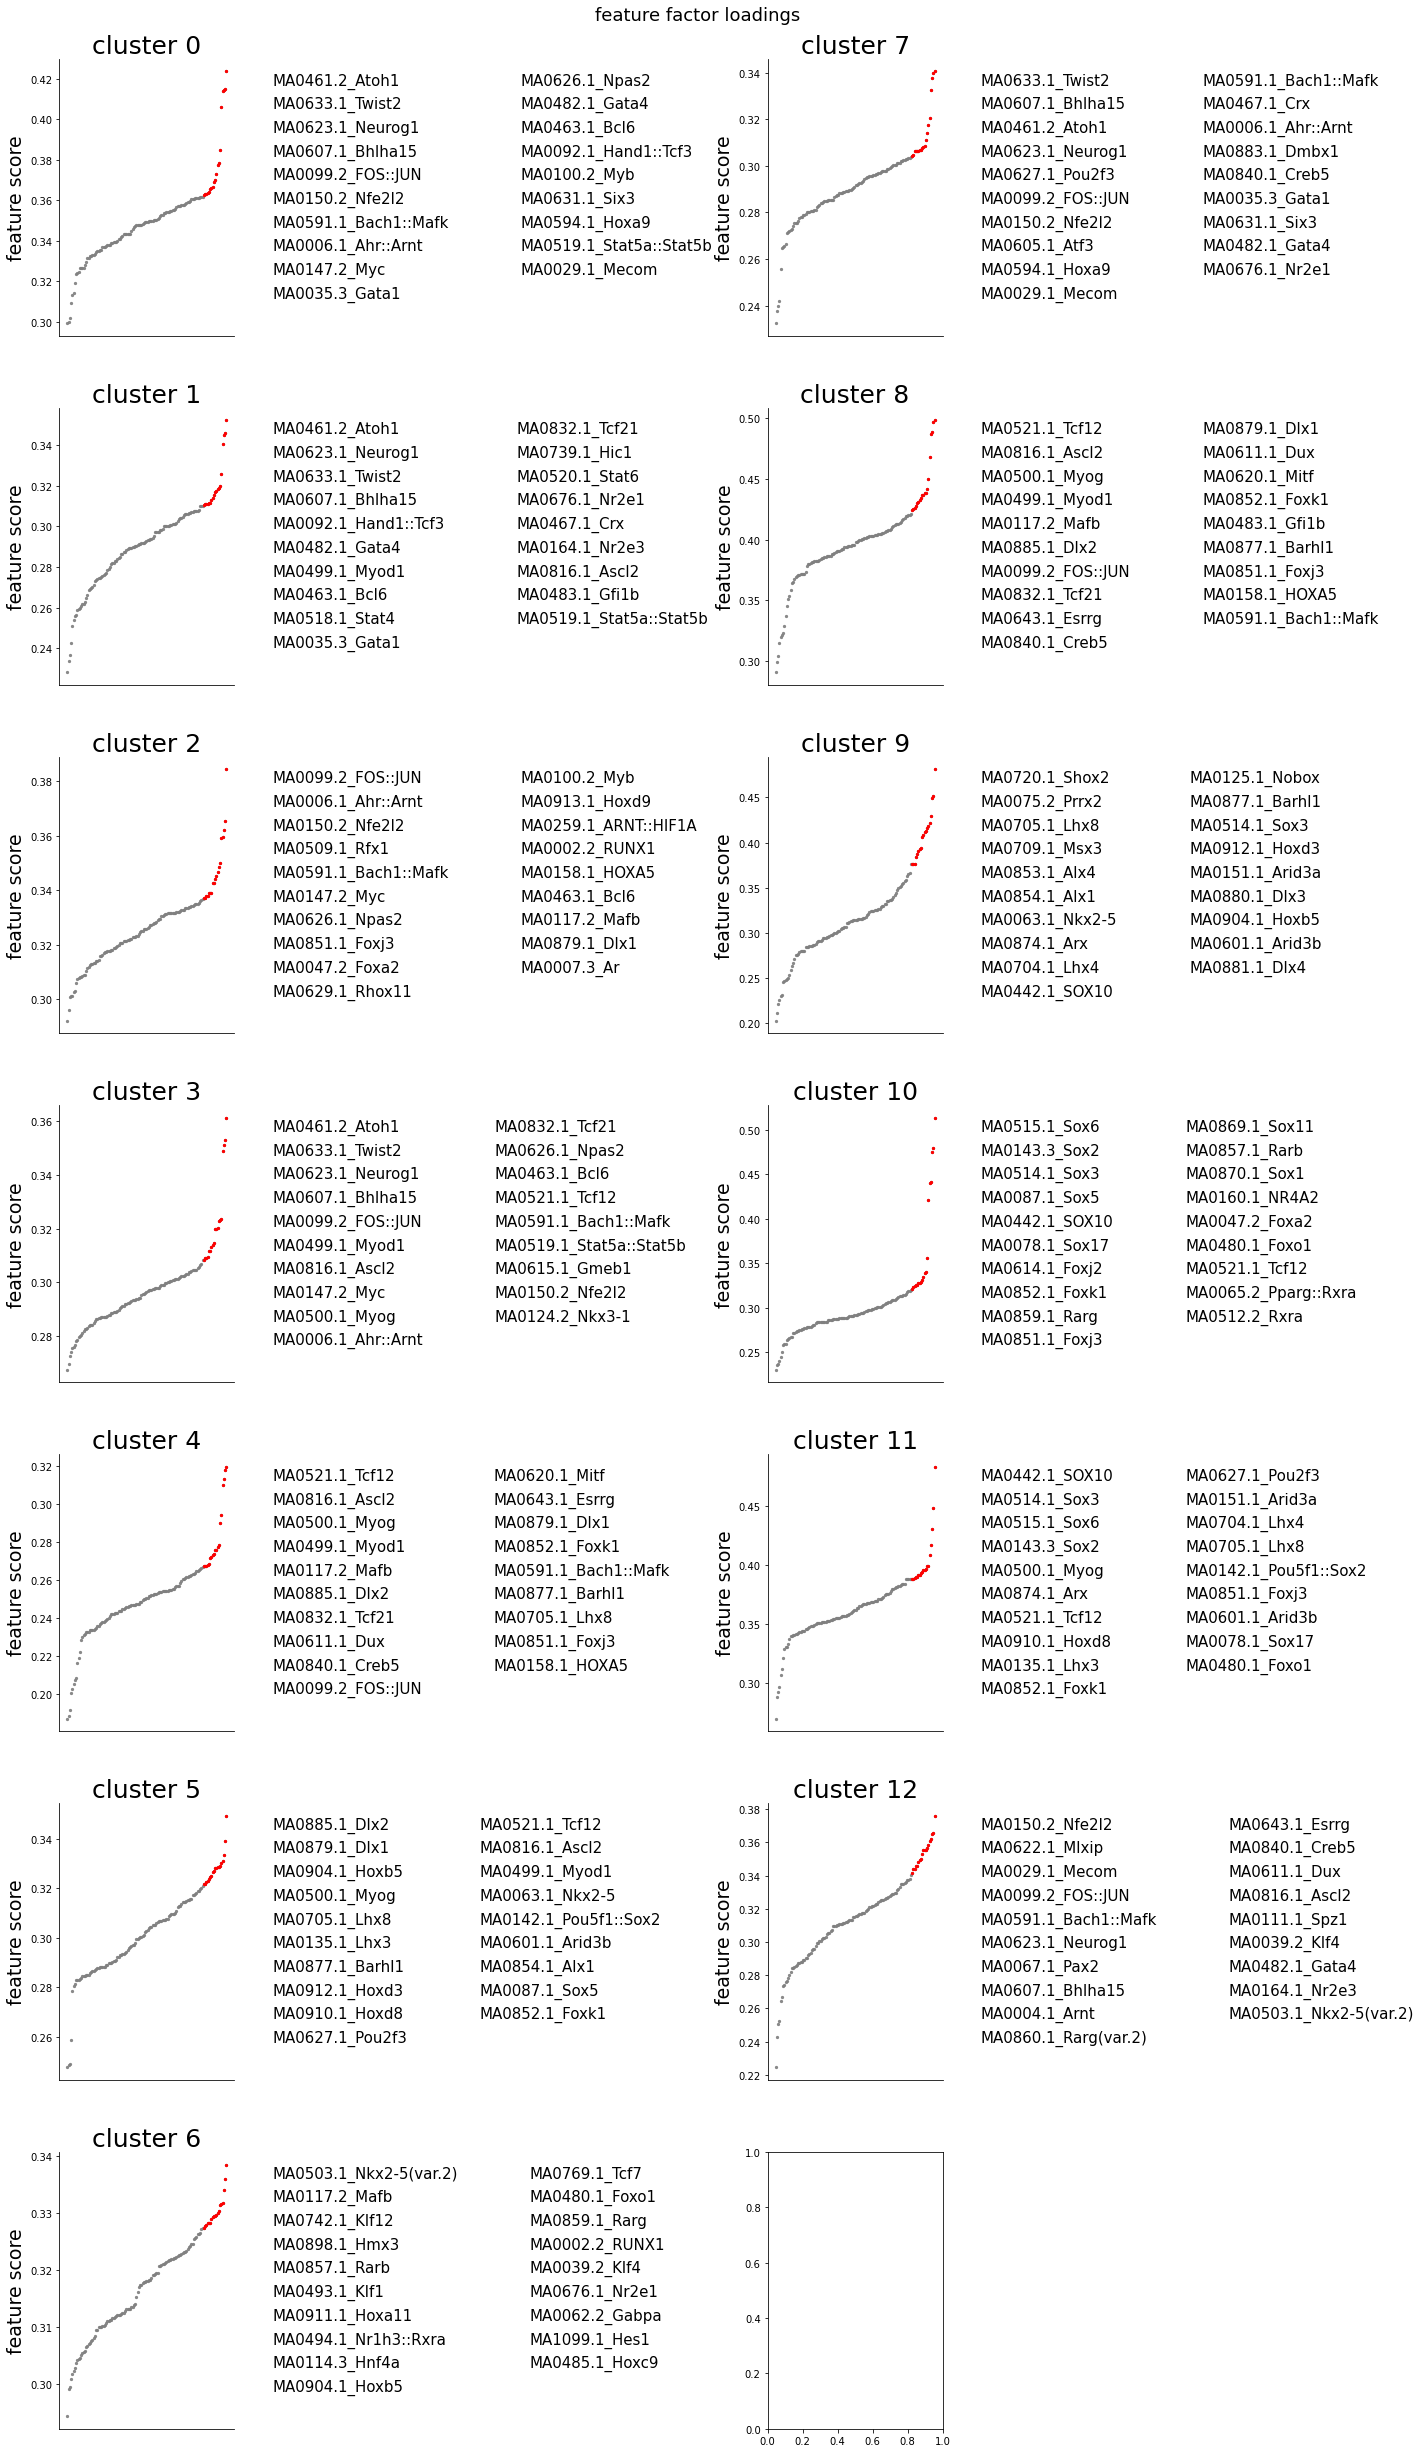

In [8]:
# Plot
C_gene = C_feats["rna"]
scmomat.plot_feat_score(C_gene, n_feats = 20, figsize= (15,35), save_as = None, title = "gene factor")

C_motif = C_feats["motif"]
scmomat.plot_feat_score(C_motif, n_feats = 20, figsize= (20,35), save_as = None, title = "motif factor")
